In [1]:
# !usr/bin/python
# -*- encoding: utf-8 -*-
# Project: Densely connected convolutional networks
# Author: Tracy Tao
# Date: 2022/04/12
import torch 
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

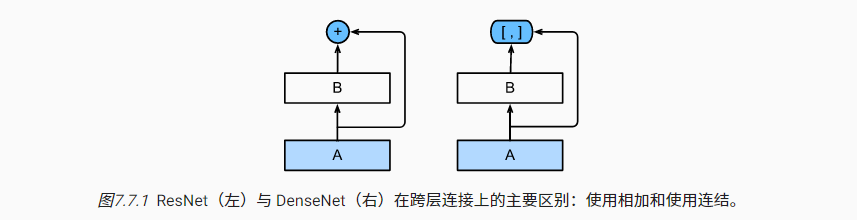
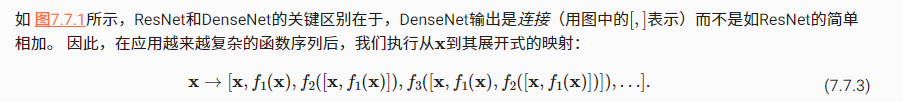
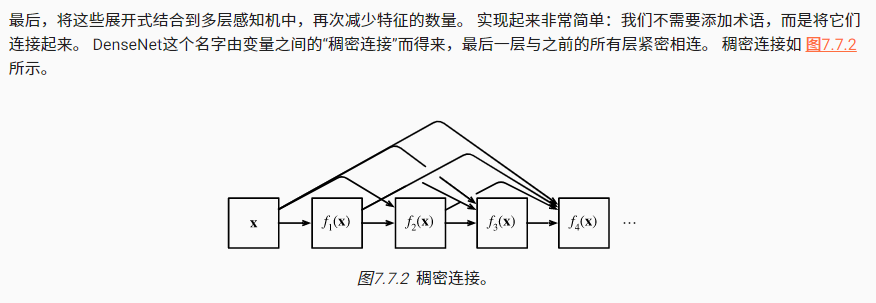

In [7]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(nn.BatchNorm2d(input_channels), nn.ReLU(),
                         nn.Conv2d(input_channels, num_channels, kernel_size =3, padding =1))

In [8]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels *i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)
    
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X,Y), dim=1)
        return X

In [9]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

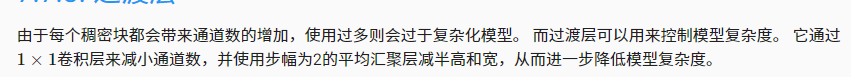
- DenseBlock内部可以采用**bottleneck层**来减少计算量，主要是原有的结构中增加1x1 Conv

In [12]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(nn.BatchNorm2d(input_channels), nn.ReLU(),
                         nn.Conv2d(input_channels, num_channels, kernel_size =1),
                         nn.AvgPool2d(kernel_size =2 , stride=2))

In [13]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

In [14]:
# DenseNet首先使用同ResNet一样的单卷积层和最大汇聚层。
b1 =nn.Sequential(nn.Conv2d(1, 64, kernel_size = 7, stride=2, padding=3),
                  nn.BatchNorm2d(64), nn.ReLU(),
                  nn.MaxPool2d(kernel_size =3, stride=2, padding=1))

In [17]:
# DenseNet使用的是4个稠密块
# 稠密块里的卷积层通道数（即增长率）设为32，所以每个稠密块将增加128个通道。
# DenseNet则使用过渡层来减半高和宽，并减半通道数。
num_channels, growth_rate = 64,32
num_convs_in_dense_blocks = [4 for i in range(4)]
blks=[]
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    num_channels += num_convs * growth_rate # 增加一个稠密快，增加的通道数
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2
    

In [18]:
# 最后接上全局汇聚层和全连接层来输出结果。
net = nn.Sequential(b1, # 单卷积层 + maxpooling
                    *blks, # DenseBlock
                    nn.BatchNorm2d(num_channels), nn.ReLU(), #BN + relu
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(),
                    nn.Linear(num_channels,10))

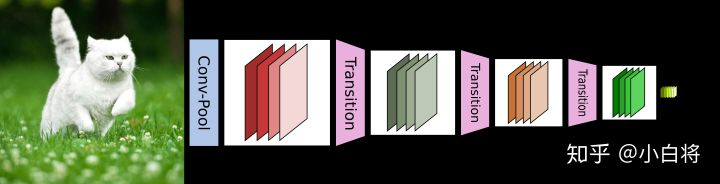
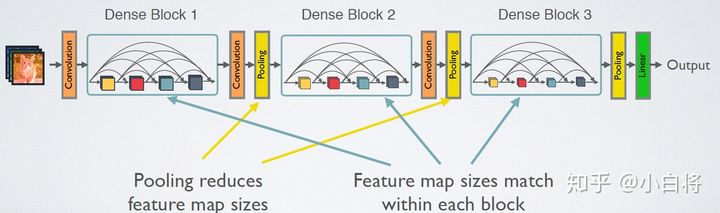
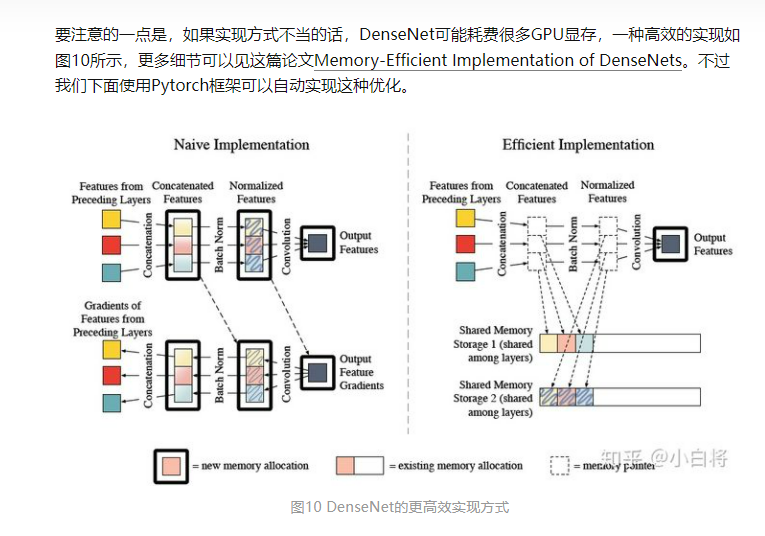
- 选取最大池化的想法是：若我们需要的对象，偏向于纹理轮廓等特征。选取最大池化可以过滤掉比较多的无用信息。特点更鲜明。
- 选取平均池化的想法是：若我们需要的对象偏向于整体特性，防止丢失太多的高维信息